# Michaelis-Menten model

Here we are going to explore a simple Michaelis-Menten model whose reaction
rate constants are known (latter in the tutorials we are going to explore many
ways of calculating rate constants).

$$
\require{mhchem}
\ce{E + S <=>[k_\text{f}][k_\text{r}] ES -> ES^{\ddagger} ->[k_\text{cat}] E + P}
$$

The above model translates to the following in overreact:

In [1]:
from overreact import core, simulate
scheme = core.parse_reactions("E + S <=> ES -> ES‡ -> E + P")

Among the return values we have compounds and reactions:

In [2]:
scheme.compounds

('E', 'S', 'ES', 'ES‡', 'P')

In [3]:
scheme.reactions

('E + S -> ES', 'ES -> E + S', 'ES -> E + P')

All compounds and reactions are parsed in the order they appear in the model.
Observe that the $\ce{ES^{\ddagger}}$ transition state was correctly
understood and removed from where it should (this will matter in future
tutorials, but just ignore it for now). The other return values are going to be
discussed latter.

### Defining the reaction rate constants

In order to simulate a plausible microkinetics model, we are going to use
experimental reaction rate constants. Values for some enzymes are
[available at Wikipedia](https://en.wikipedia.org/wiki/Michaelis%E2%80%93Menten_kinetics#Applications>)
and reproduced below:

| Enzyme             | $K_\text{M}$ | $k_\text{cat}$ |
| ------------------ | ------------ | -------------: |
| Chymotrypsin       |     0.015000 | 	        0.14 |
| Pepsin             |     0.000300 |           0.50 |
| T-RNA synthetase   |     0.000900 |           7.60 |
| Ribonuclease       |     0.007900 |         790.00 |
| Carbonic anhydrase |     0.026000 |      400000.00 |
| Fumarase           |     0.000005 |         800.00 |

In the table, $K_\text{M}$ is in molar units ($\text{M}$) and
$k_\text{cat}$ is in $\text{s}^{-1}$. Using the relationship

$$
K_\text{M} = \frac{k_\text{r} + k_\text{cat}}{k_\text{f}}
$$

and a reasonable guess for $k_\text{r}$, we are able to obtain all the
constants we need for the model. We set $k_\text{r}$ large enough so as
to kept the hypothesis of fast equilibrium valid:

In [4]:
k_r = 1.0e11  # larger than any other reaction rate in the table above

Below, the rate constants are calculated for the protease [Pepsin](https://en.wikipedia.org/wiki/Pepsin). First we declare variables with the
values from the table:

In [5]:
K_M, k_cat = 0.000300, 0.50  # Pepsin

We need one reaction rate constant per reaction, in a
list with the same ordering as the ``scheme.reactions`` variable obtained above.

In [6]:
import numpy as np

k_f = (k_r + k_cat) / K_M  # using the equation above
k = np.array([k_f, k_r, k_cat])

### Solving the initial value problem

Next, we are going to define a set of initial concentrations (you can use any
units, as long as they match with the reaction rate constants) and solve the
initial value problem. Below we set the substrate to one molar and the enzyme
to 5% of it:

In [7]:
y0 = np.array([0.05, 1.00, 0.00, 0.00, 0.00])

One return value that ``core.parse_reactions`` has given us was the $A$
matrix, whose entry $A_{ij}$ stores the coefficient of the i-th compound
in the j-th reaction:

In [8]:
scheme.A

((-1.0, 1.0, 1.0),
 (-1.0, 1.0, 0.0),
 (1.0, -1.0, -1.0),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0))

Observe that negative (positive) entries represent reactants (products) and a
line full of zeros represents transition states (which is to say that they are
formed and destroyed instantly). The matrix $A$ allows us to write the
differential equations for this reaction scheme in a compact way
($c_\ce{X}$ means the concentration of $\ce{X}$ at time t):

$$
\dot{y}
= \frac{d}{dt}
  \begin{bmatrix}
    c_\ce{E} \\
    c_\ce{S} \\
    c_\ce{ES} \\
    c_{\ce{ES^{\ddagger}}} \\
    c_\ce{P}
  \end{bmatrix}
  = \begin{bmatrix}
      - k_\text{f} c_\ce{E} c_\ce{S} + k_\text{r} c_\ce{ES} + k_\text{cat} c_\ce{ES} \\
      - k_\text{f} c_\ce{E} c_\ce{S} + k_\text{r} c_\ce{ES} \\
      + k_\text{f} c_\ce{E} c_\ce{S} - k_\text{r} c_\ce{ES} - k_\text{cat} c_\ce{ES} \\
      0 \\
      + k_\text{cat} c_\ce{ES}
    \end{bmatrix}
    = A \begin{bmatrix}
          k_\text{f} c_\ce{E} c_\ce{S} \\
          k_\text{r} c_\ce{ES} \\
          k_\text{cat} c_\ce{ES}
        \end{bmatrix}
      = A r
$$

where $r$ is the vector of reaction rates, the single entity that depends
(likely non-linearly) both on the concentration vector $y$ and the vector
of reaction rate constants $k$.

Fortunately, overreact is able to give you a function that, giving time and
concentrations, calculates the derivative with respect to time:

In [9]:
dydt = simulate.get_dydt(scheme, k)
dydt(0.0, y0)  # t = 0.0  # doctest: +SKIP

DeviceArray([-1.66666667e+13, -1.66666667e+13,  1.66666667e+13,
              0.00000000e+00,  0.00000000e+00], dtype=float64)

From the above we see that the equilibrium will likely be rapidly satisfied,
while no product is being created at time zero, since there's no
enzyme-substrate complex yet.

Let's now do a one minute simulation with ``get_y``:

In [10]:
y, r = simulate.get_y(dydt, y0)
t = np.linspace(y.t_min, 60.0)  # seconds

We can graph concentrations over time with ``t`` and ``y``:

Text(0, 0.5, 'Concentration (M)')

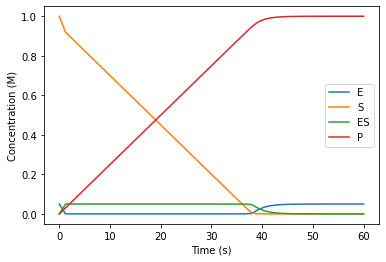

In [11]:
import matplotlib.pyplot as plt

for i, compound in enumerate(scheme.compounds):
   if not compound.endswith("‡"):
       plt.plot(t, y(t)[i], label=compound)
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Concentration (M)")

A one-minute simulation of the Michaelis-Menten model for the enzyme Pepsin,
an endopeptidase that breaks down proteins into smaller peptides. Observe
that the rapid equilibrium justifies the commonly applied steady-state
approximation.

The simulation time was enough to convert all substrate into products and
regenerate the initial enzyme molecules:

In [12]:
y(y.t_max)  # doctest: +SKIP

array([ 5.00000000e-02, -9.80981299e-17, -1.09377090e-17,  0.00000000e+00,
        1.00000000e+00])

### Getting rates back

From the solution above, we can get the rate of production formation over time:

Text(0, 0.5, 'Time derivative of concentration (M/s)')

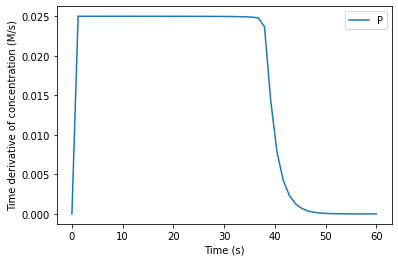

In [13]:
import numpy as np

dy = np.array([dydt(t, y) for t, y in zip(t, y(t).T)]).T

plt.plot(t, dy[scheme.compounds.index("P")], label="P")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Time derivative of concentration (M/s)")

The time derivative of concentrations for the one-minute simulation of the Michaelis-Menten model for the enzyme Pepsin above.

Furthermore, we can get the turnover frequency (TOF) as:

Text(0, 0.5, 'Turover frequency (1/s)')

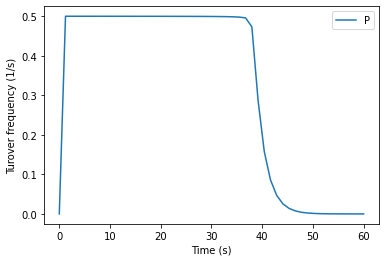

In [14]:
total_enzyme = y(t)[scheme.compounds.index("E"), :] + y(t)[scheme.compounds.index("ES"), :]
tof = dy[scheme.compounds.index("P")] / total_enzyme

plt.plot(t, tof, label="P")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Turover frequency (1/s)")

The turnover frequency for the enzyme Pepsin above, in the one-minute simulation of the Michaelis-Menten model.